In [1]:

import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import pandas as pd
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import librosa
import librosa.display
import matplotlib.pyplot as plt


In [2]:
labels_df = pd.read_excel('./data/data/NEW_IRB300012145_Patient_ID_deidentified.xlsx')
Smokeing_status = labels_df.iloc[:, 4].to_list()

Smokeing_status[149]

'never'

In [3]:
import torchaudio.transforms as T

class AmplitudeNormalization:
    def __call__(self, waveform):
        # Normalize the waveform to be within [-1, 1]
        peak = waveform.abs().max()
        if peak > 0:
            waveform = waveform / peak
        return waveform

# To use it:
# waveform, sample_rate = torchaudio.load('path/to/audio.wav')
# waveform = AmplitudeNormalization()(waveform)


class PadTrimAudio:
    def __init__(self, max_len):
        self.max_len = max_len

    def __call__(self, waveform):
        if waveform.size(1) > self.max_len:
            # Trim the waveform if longer than max_len
            waveform = waveform[:, :self.max_len]
        elif waveform.size(1) < self.max_len:
            # Pad with zeros if shorter than max_len
            padding_size = self.max_len - waveform.size(1)
            waveform = torch.nn.functional.pad(waveform, (0, padding_size), "constant", 0)

        if waveform.size(0) < 128:
            padding_size = 128 - waveform.size(0)
            waveform = torch.nn.functional.pad(waveform, (padding_size, 0), "constant", 0)
        return waveform

from sklearn.preprocessing import StandardScaler
import numpy as np

class FeatureNormalization:
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, features):
        # Fit the scaler on the training set features
        self.scaler.fit(features)

    def transform(self, features):
        # Apply normalization to features
        return self.scaler.transform(features)

In [57]:
label_to_int = {
    'N': 0,
    'Y': 1
}

label_to_int['N']

0

In [27]:
label_to_int = {
    'F': 0,
    'M': 1
}


In [4]:
label_to_int = {
    'current': 1,
    'former': 1,
    'never': 0
}

label_to_int['current']

1

In [5]:
class SoundDataset(Dataset):
    def __init__(self, data_dir, labels_df, transform=None, max_len=500):
        self.data_dir = data_dir
        self.labels_df = labels_df
        self.transform = transform
        self.max_len = max_len
        # self.orderlist = ['RLP.wav', 'RUP.wav', 'RUA Hum.wav', 'LUA Hum.wav', 'RUA.wav', 'RMP.wav', 'LMP.wav', 'LUA.wav', 'LLP.wav', 'LUP.wav']
        self.orderlist = ['a.wav', 'a_high.wav', 'a_low.wav', 'consent.wav', 'cough_n.wav', 'e.wav', 'e_high.wav', 'e_low.wav', 'pain_rating.wav', 'SOB_rating.wav', 'two_roads.wav']


    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        patient_id = str(idx+1).zfill(3)
        # audio_dir = os.path.join(self.data_dir, str(patient_id), 'breath Eko')
        audio_dir = os.path.join(self.data_dir, str(patient_id), 'Voice')
        audio_file = [os.path.join(audio_dir, f) for f in os.listdir(audio_dir) if f.endswith('.wav') and 'cough' in f][0]


        y, sr = librosa.load(audio_file, sr=None)


        D = librosa.stft(y, n_fft=2048, hop_length=512)  # n_fft and hop_length can be adjusted based on your needs
        S = np.abs(D) ** 2  # Convert to power spectrum
        mel_spec = librosa.feature.melspectrogram(S=S, sr=sr, n_mels=128)

            # print(mel_spec)
            # plt.figure(figsize=(10, 4))
            # librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), sr=sr, hop_length=512, x_axis='time', y_axis='mel')
            # plt.colorbar(format='%+2.0f dB')
            # plt.title('Mel spectrogram')
            # plt.tight_layout()
            # plt.show()
            # print(len(y))
            # print(sr)

            # if self.transform:
            #     waveform = self.transform(waveform)
        waveform = PadTrimAudio(self.max_len)(torch.tensor(mel_spec))


        label = label_to_int[self.labels_df[idx]]

        return waveform, label

transform = AmplitudeNormalization()
data_dir = './data/data/Patients'
sound_dataset = SoundDataset(data_dir, Smokeing_status, transform=transform)

train_dataset, test_dataset = random_split(sound_dataset, [180, 20])

traindataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
testdataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

dataloader = DataLoader(sound_dataset, batch_size=20, shuffle=True)

In [6]:
for batch in traindataloader:
    waveforms, labels = batch
    print(waveforms.shape)
    print(labels)

torch.Size([4, 128, 500])
tensor([1, 1, 0, 0])
torch.Size([4, 128, 500])
tensor([1, 0, 1, 0])
torch.Size([4, 128, 500])
tensor([1, 0, 0, 0])
torch.Size([4, 128, 500])
tensor([0, 1, 1, 1])
torch.Size([4, 128, 500])
tensor([0, 0, 1, 0])
torch.Size([4, 128, 500])
tensor([0, 1, 0, 0])
torch.Size([4, 128, 500])
tensor([1, 0, 0, 0])
torch.Size([4, 128, 500])
tensor([0, 0, 0, 0])
torch.Size([4, 128, 500])
tensor([0, 1, 0, 0])
torch.Size([4, 128, 500])
tensor([0, 0, 1, 0])
torch.Size([4, 128, 500])
tensor([1, 0, 0, 0])
torch.Size([4, 128, 500])
tensor([0, 0, 1, 0])
torch.Size([4, 128, 500])
tensor([1, 1, 0, 1])
torch.Size([4, 128, 500])
tensor([1, 0, 1, 0])
torch.Size([4, 128, 500])
tensor([0, 1, 1, 1])
torch.Size([4, 128, 500])
tensor([0, 1, 0, 0])
torch.Size([4, 128, 500])
tensor([0, 0, 1, 0])
torch.Size([4, 128, 500])
tensor([1, 1, 1, 0])
torch.Size([4, 128, 500])
tensor([0, 0, 0, 0])
torch.Size([4, 128, 500])
tensor([1, 1, 1, 0])
torch.Size([4, 128, 500])
tensor([0, 1, 0, 1])
torch.Size([4

In [7]:
for batch in testdataloader:
    waveforms, labels = batch
    print(waveforms.shape)
    print(labels)

torch.Size([4, 128, 500])
tensor([0, 0, 0, 0])
torch.Size([4, 128, 500])
tensor([1, 0, 0, 1])
torch.Size([4, 128, 500])
tensor([0, 0, 0, 0])
torch.Size([4, 128, 500])
tensor([0, 1, 0, 0])
torch.Size([4, 128, 500])
tensor([0, 0, 0, 0])


In [8]:
class AudioClassifier(nn.Module):
    def __init__(self):
        super(AudioClassifier, self).__init__()
        # Adjusted the number of input channels to 1280
        self.conv1 = nn.Conv1d(128, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(32, 32, kernel_size=3, stride=1, padding=1)

        # Calculate the size of the output from the last conv layer to pass to the first linear layer
        initial_length = 500  # Initial length of the signal
        final_conv_length = self._get_conv1d_output_size(initial_length, 3, 1, 1, 2)  # After first conv and pool
        final_conv_length = self._get_conv1d_output_size(final_conv_length, 3, 1, 1, 2)  # After second conv and pool

        self.fc1 = nn.Linear(32 * final_conv_length, 128)  # Linear layer for feature reduction
        self.fc2 = nn.Linear(128, 2)  # Output layer for 3 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # Flatten from the second dimension onward
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def _get_conv1d_output_size(self, L, kernel_size, stride, padding, pool):
        # Utility function to calculate the size of the output of a conv1d layer after pooling
        L = (L + 2 * padding - kernel_size) // stride + 1
        L = L // pool
        return L

class MLPClassifier(nn.Module):
    def __init__(self):
        super(MLPClassifier, self).__init__()
        # Flatten the input from 1280x1000 to 1280000
        self.fc1 = nn.Linear(1280 * 1000, 1024)  # First fully connected layer
        self.fc2 = nn.Linear(1024, 512)          # Second fully connected layer
        self.fc3 = nn.Linear(512, 3)             # Output layer for 3 classes

    def forward(self, x):
        # Flatten the input
        x = x.view(-1, 1280 * 1000)  # Ensure input tensor is reshaped to (batch_size, 1280*1000)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation function here as it will be used with CrossEntropyLoss
        return x

In [18]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def test_model(model, test_loader, device='cpu'):
    """
    Tests the given model on the provided test data loader.

    Parameters:
        model (torch.nn.Module): The model to test.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test set.
        device (str): Device to run the model on ('cpu' or 'cuda').

    Returns:
        float: Accuracy of the model on the test set.
    """
    # Set the model to evaluation mode
    model.eval()
    model.to(device)

    correct = 0
    total = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)


            true_labels += labels
            softmax = nn.Softmax()
            predictions += softmax(outputs)[:,1]
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print(labels)
            print(predicted)



    fpr, tpr, thresholds = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)

    # Print AUC value
    print('AUC: %0.2f' % roc_auc)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')


    return accuracy




Epoch 1, Loss: 1.9811, Accuracy: 56.67%
tensor([0, 0, 0, 0])
tensor([0, 0, 1, 0])
tensor([1, 0, 0, 1])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 1, 0, 0])
tensor([0, 1, 0, 0])
tensor([0, 0, 0, 0])


C:\Users\RichardFan\AppData\Local\Temp\ipykernel_21160\1088406581.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions += softmax(outputs)[:,1]


tensor([0, 0, 0, 0])
tensor([1, 0, 0, 1])
AUC: 0.37


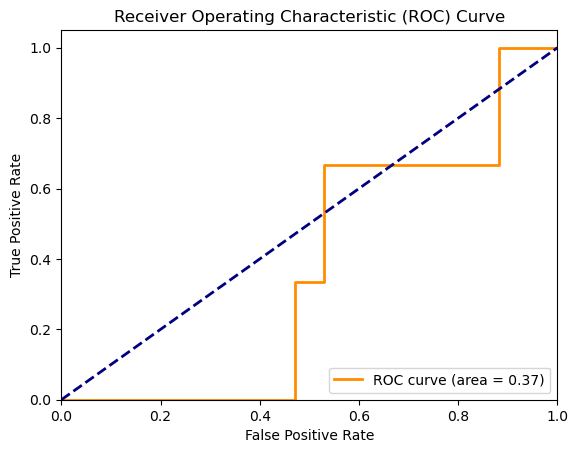

Accuracy of the model on the test set: 65.00%
Epoch 2, Loss: 0.4281, Accuracy: 82.22%
tensor([0, 0, 0, 0])
tensor([0, 0, 1, 0])
tensor([1, 0, 0, 1])
tensor([1, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 1, 0, 0])
tensor([0, 1, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([1, 0, 0, 0])
AUC: 0.49


C:\Users\RichardFan\AppData\Local\Temp\ipykernel_21160\1088406581.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions += softmax(outputs)[:,1]


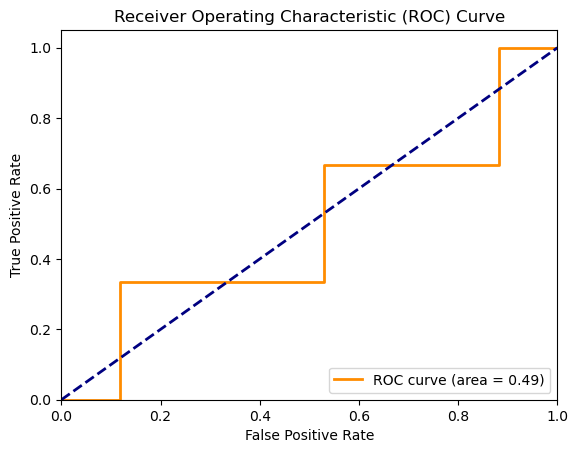

Accuracy of the model on the test set: 75.00%
Epoch 3, Loss: 0.2091, Accuracy: 92.22%
tensor([0, 0, 0, 0])
tensor([0, 0, 1, 0])
tensor([1, 0, 0, 1])
tensor([1, 0, 1, 0])
tensor([0, 0, 0, 0])
tensor([0, 1, 0, 0])
tensor([0, 1, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([1, 1, 0, 0])
AUC: 0.57


C:\Users\RichardFan\AppData\Local\Temp\ipykernel_21160\1088406581.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions += softmax(outputs)[:,1]


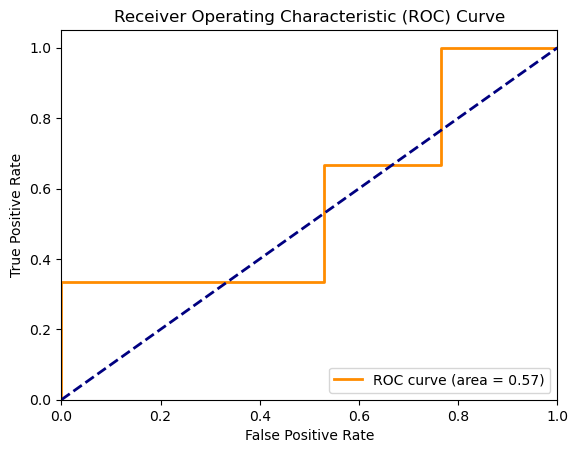

Accuracy of the model on the test set: 65.00%
Epoch 4, Loss: 0.0790, Accuracy: 98.33%
tensor([0, 0, 0, 0])
tensor([0, 0, 1, 0])
tensor([1, 0, 0, 1])
tensor([1, 0, 1, 0])
tensor([0, 0, 0, 0])
tensor([0, 1, 0, 0])
tensor([0, 1, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([1, 1, 0, 0])
AUC: 0.57


C:\Users\RichardFan\AppData\Local\Temp\ipykernel_21160\1088406581.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions += softmax(outputs)[:,1]


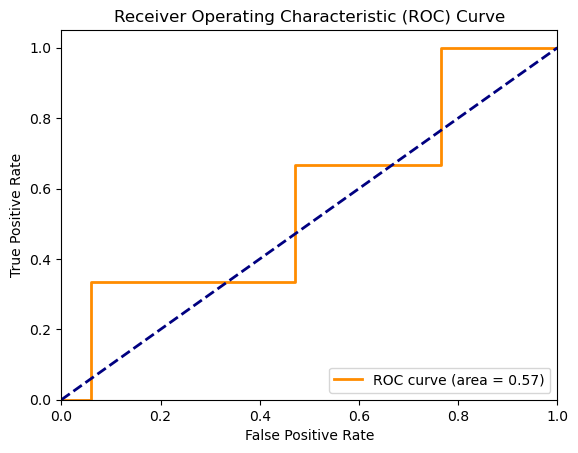

Accuracy of the model on the test set: 65.00%
Epoch 5, Loss: 0.0287, Accuracy: 100.00%
tensor([0, 0, 0, 0])
tensor([0, 0, 1, 0])
tensor([1, 0, 0, 1])
tensor([1, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 1, 0, 0])
tensor([0, 1, 0, 0])
tensor([0, 0, 0, 0])


C:\Users\RichardFan\AppData\Local\Temp\ipykernel_21160\1088406581.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions += softmax(outputs)[:,1]


tensor([0, 0, 0, 0])
tensor([1, 1, 0, 0])
AUC: 0.53


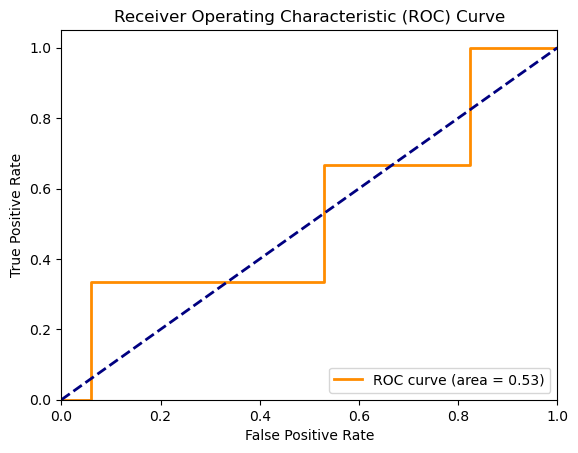

Accuracy of the model on the test set: 70.00%
Epoch 6, Loss: 0.0136, Accuracy: 100.00%
tensor([0, 0, 0, 0])
tensor([0, 0, 1, 0])
tensor([1, 0, 0, 1])
tensor([1, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 1, 0, 1])
tensor([0, 1, 0, 0])
tensor([0, 0, 0, 0])


C:\Users\RichardFan\AppData\Local\Temp\ipykernel_21160\1088406581.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions += softmax(outputs)[:,1]


tensor([0, 0, 0, 0])
tensor([1, 1, 0, 0])
AUC: 0.59


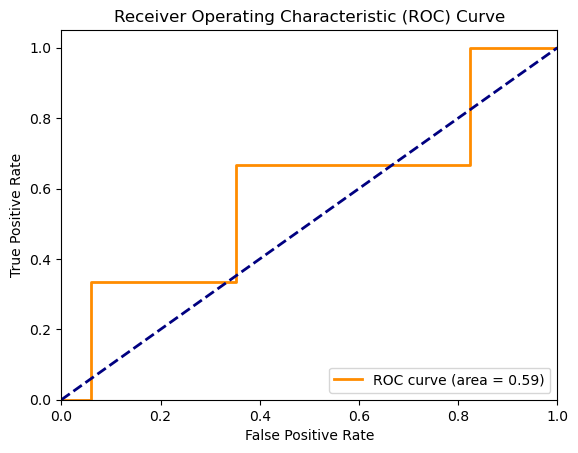

Accuracy of the model on the test set: 65.00%
Epoch 7, Loss: 0.0068, Accuracy: 100.00%
tensor([0, 0, 0, 0])
tensor([0, 0, 1, 0])
tensor([1, 0, 0, 1])
tensor([1, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 1, 0, 1])
tensor([0, 1, 0, 0])
tensor([0, 0, 0, 0])


C:\Users\RichardFan\AppData\Local\Temp\ipykernel_21160\1088406581.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions += softmax(outputs)[:,1]


tensor([0, 0, 0, 0])
tensor([1, 1, 0, 0])
AUC: 0.59


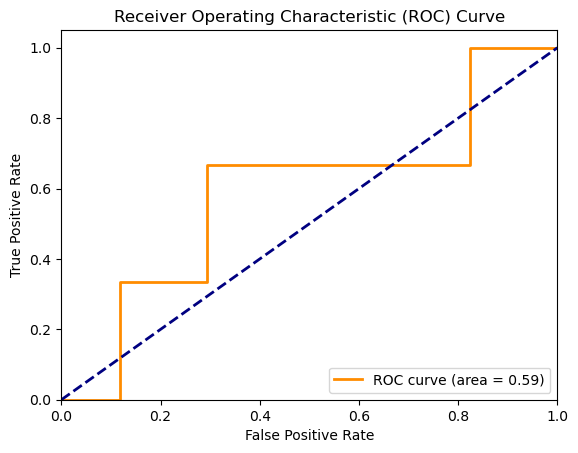

Accuracy of the model on the test set: 65.00%
Epoch 8, Loss: 0.0039, Accuracy: 100.00%
tensor([0, 0, 0, 0])
tensor([0, 0, 1, 0])
tensor([1, 0, 0, 1])
tensor([1, 0, 0, 1])
tensor([0, 0, 0, 0])
tensor([0, 1, 0, 1])
tensor([0, 1, 0, 0])
tensor([0, 0, 0, 0])


C:\Users\RichardFan\AppData\Local\Temp\ipykernel_21160\1088406581.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions += softmax(outputs)[:,1]


tensor([0, 0, 0, 0])
tensor([1, 1, 0, 0])
AUC: 0.59


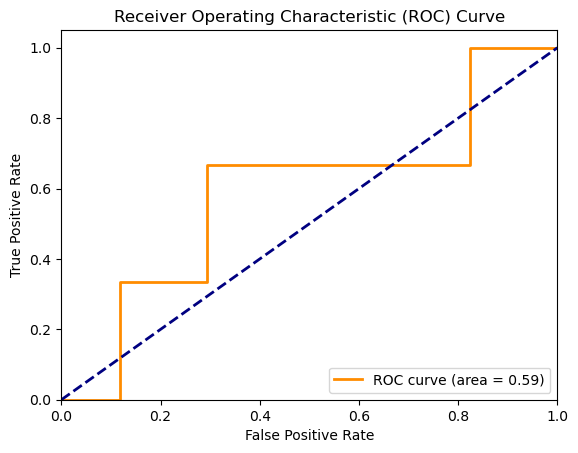

Accuracy of the model on the test set: 70.00%
Epoch 9, Loss: 0.0026, Accuracy: 100.00%
tensor([0, 0, 0, 0])
tensor([0, 0, 1, 0])
tensor([1, 0, 0, 1])
tensor([1, 0, 0, 1])
tensor([0, 0, 0, 0])
tensor([0, 1, 0, 1])
tensor([0, 1, 0, 0])
tensor([0, 0, 0, 0])


C:\Users\RichardFan\AppData\Local\Temp\ipykernel_21160\1088406581.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions += softmax(outputs)[:,1]


tensor([0, 0, 0, 0])
tensor([1, 1, 0, 0])
AUC: 0.59


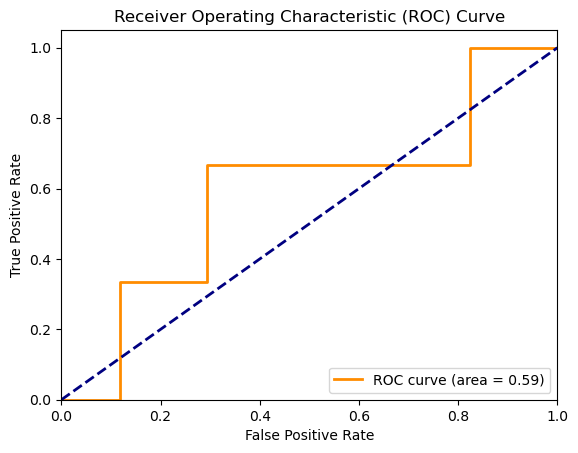

Accuracy of the model on the test set: 70.00%
Epoch 10, Loss: 0.0017, Accuracy: 100.00%
tensor([0, 0, 0, 0])
tensor([0, 0, 1, 0])
tensor([1, 0, 0, 1])
tensor([1, 0, 0, 1])
tensor([0, 0, 0, 0])
tensor([0, 1, 0, 1])
tensor([0, 1, 0, 0])
tensor([0, 0, 0, 0])
tensor([0, 0, 0, 0])
tensor([1, 1, 0, 0])


C:\Users\RichardFan\AppData\Local\Temp\ipykernel_21160\1088406581.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predictions += softmax(outputs)[:,1]


AUC: 0.61


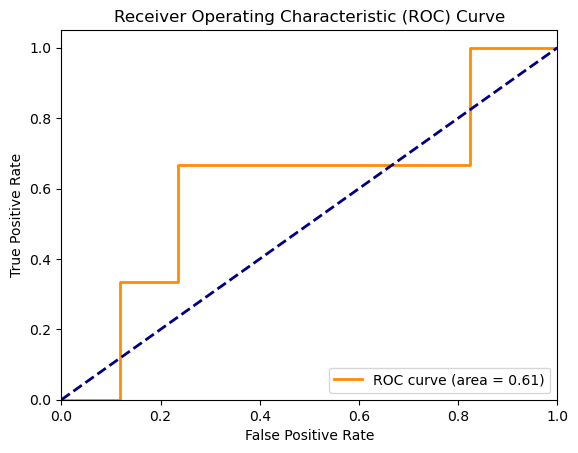

Accuracy of the model on the test set: 70.00%


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AudioClassifier().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train(model, device, train_loader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0

        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(data)  # Add channel dimension
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            # print(total)
        avg_loss = total_loss / len(train_loader)
        accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
        accuracy = test_model(model, testdataloader, device)

train(model, device, traindataloader, optimizer, criterion)
